# Implementar o DCGAN no MNIST dataset

In [7]:
# import struct
# import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from  torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# import argparse
import os
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
dataroot = "/home/ninja/MNIST/training/"        # Root directory for dataset
workers = 4                    # Number of workers for dataloader
batch_size = 256               # Batch size during training
image_size =64
ngpu = 1                       # Number of GPUs available. Use 0 for CPU mode.

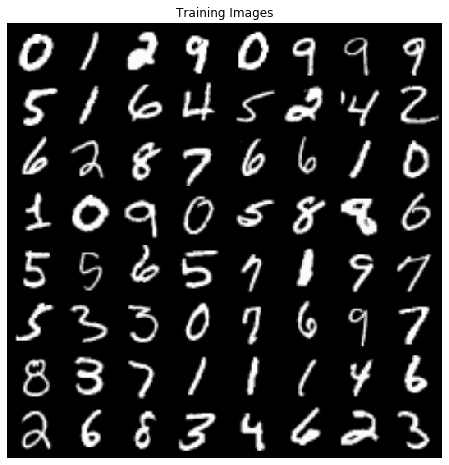

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # usar apenas se tiver mais de um canal
                           ]))
# Create the dataloader
dataloader = Data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

---
* Funções de auxílio

In [9]:
def plot_losses(losses_his,title='losses'):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def plot_digit(x):
    x = x.data.numpy().reshape(data1.shape[1],data1.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.show()
    
def plot_n_random_digits(x,labels=None,n_images=9,title='gan_random_digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data1.shape[1],data1.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(15,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
    plt.tight_layout()
#     plt.savefig('images/'+title+'.png',quality=100)
    plt.show()

def print_label(label):
    chosen_label = label
    batch = 1000
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, Z_dim)).cuda(),
                         y_sample_tc.type(torch.FloatTensor).cuda()).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))
    
def nets_test(n_sample,G,D):
    z = Variable(torch.randn(n_sample, nz)).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,l)
    IS = Inception_Score(x,g)
    D_real = D(x,l)
    D_fake = D(g,l)
    print('Average D_real  {:.4f}| Std D_real  {:.4f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.4f}| Std D_fake  {:.4f}'.format(D_fake.mean(),D_fake.std()))
    print('Inception Score  {:.4f}|'.format(IS))
    

    
def get_X(n_sample):
    z = noise(n_sample, nz)
    return G(z).cpu()

def noise(n_sample,nz):
    return torch.randn(n_sample, nz, 1, 1).cuda()

def plot_from_latent():
    fake1 = get_X(n_sample=64)
    plt.figure(figsize=(20,5))
    plt.axis("off")
    plt.title(f"Fake Images:")
    plt.imshow(np.transpose(vutils.make_grid(fake1[:64], padding=5, normalize=True).cpu(),(1,2,0)))   
    plt.show()

# Funções para critério de parada
def KL(q,p):
    return torch.mean(torch.sum(-torch.log(q+ 1e-8) + torch.log(p+ 1e-8), dim=1))

def Inception_Score(q,p):
    return torch.exp(KL(q,p))

In [ ]:
nets_test(10,G,D)

---

![](images/dcgan_generator.png)

In [5]:
nc, nz, ngf, ndf = [1,100,64,64]

# Generator
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            torch.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Sigmoid())

    def forward(self, z):
        return self.main(z)

# Discriminator   
class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G = GNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
G.apply(weights_init)
D = DNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
D.apply(weights_init)

lrg = 0.001
lrd = 0.0002
beta = 0.5

G_optim = optim.Adam(G.parameters(), lr=lrg, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lrd, betas=(beta,0.999))

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

loss = torch.nn.BCELoss()
real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

G__losses, D_losses Inception_loss= [[],[],[]]
# losses_his = [G_his,D_his,] 
img_list = []

In [69]:
%%time

iters = 0
num_epochs = 5

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        D.zero_grad()
        X = data[0].to(device)
        X_size = X.size(0)
        ones = torch.full((X_size,), real_label, device=device)
        X_real_out = D(X).view(-1)
        D_loss_real = loss(X_real_out, ones)
        D_loss_real.backward()
        D_loss_real_mean = X_real_out.mean().item()

        noise = torch.randn(X_size, nz, 1, 1, device=device)
        X_fake = G(noise)
        zeros = torch.full((X_size,), fake_label, device=device)
        X_fake_out = D(X_fake.detach()).view(-1)
        D_loss_fake = loss(X_fake_out, zeros)
        D_loss_fake.backward()
        D_loss_fake_mean_1 = X_fake_out.mean().item()
        D_loss = D_loss_real + D_loss_fake
        D_optim.step()
        
        inception = Inception_Score(X,X_fake)
        
        G.zero_grad()
        X_fake_out = D(X_fake).view(-1)
        G_loss = loss(X_fake_out, ones)
        G_loss.backward()
        D_loss_fake_mean_2 = X_fake_out.mean().item()
        G_optim.step()

        if i % 235 == 0:
            print("""Epoch-{}:{}/{}| D_loss: {:.3f}| G_loss: {:.3f}| D_real: {:.3f}| 
            D_fake_1: {:.3f}| D_fake_2: {:.3}""".format(
            epoch+1,i, len(dataloader), D_loss.item(), G_loss.item(),D_loss_real_mean, D_loss_fake_mean_1,D_loss_fake_mean_2))
            print("Inception Score: {:.3f}".format(inception))
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        Inception_loss.append(inception.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    print("""D_loss: {:.3f}| G_loss: {:.3f}| D_real: {:.3f}| 
            D_fake_1: {:.3f}| D_fake_2: {:.3}""".format(
            D_loss.item(), G_loss.item(),D_loss_real_mean, D_loss_fake_mean_1,D_loss_fake_mean_2))
    print("Inception Score: {:.3f}".format(inception))

Starting Training Loop...
Epoch-1:0/235| D_loss: 0.086| G_loss: 3.589| D_real: 0.941| 
            D_fake_1: 0.023| D_fake_2: 0.0379
Inception Score: 242.317
D_loss: 0.152| G_loss: 3.161| D_real: 0.952| 
            D_fake_1: 0.094| D_fake_2: 0.0516
Inception Score: 177.263
Epoch-2:0/235| D_loss: 0.211| G_loss: 4.377| D_real: 0.953| 
            D_fake_1: 0.144| D_fake_2: 0.0162
Inception Score: 194.514
D_loss: 0.692| G_loss: 1.528| D_real: 0.660| 
            D_fake_1: 0.207| D_fake_2: 0.255
Inception Score: 165.129
Epoch-3:0/235| D_loss: 0.816| G_loss: 3.349| D_real: 0.836| 
            D_fake_1: 0.426| D_fake_2: 0.0465
Inception Score: 149.969
D_loss: 0.405| G_loss: 4.037| D_real: 0.693| 
            D_fake_1: 0.008| D_fake_2: 0.0232
Inception Score: 124.804
Epoch-4:0/235| D_loss: 0.232| G_loss: 3.053| D_real: 0.965| 
            D_fake_1: 0.169| D_fake_2: 0.0593
Inception Score: 149.932
D_loss: 0.138| G_loss: 3.845| D_real: 0.948| 
            D_fake_1: 0.079| D_fake_2: 0.0264
Ince

In [70]:
noise = torch.randn(X_size, nz, 1, 1, device=device)
D(G(noise)).mean()

tensor(0.3424, device='cuda:0', grad_fn=<MeanBackward0>)

In [59]:
def stopping_inception(niters):
    data_sample = iter(dataloader)
    inception = []
    for i in range(niters):
        X1 = next(data_sample)[0]
        X2 = next(data_sample)[0]
        inception.append(Inception_Score(X1,X2).item())
    return np.mean(inception)

In [60]:
stopping_inception(100)

1.020404344201088

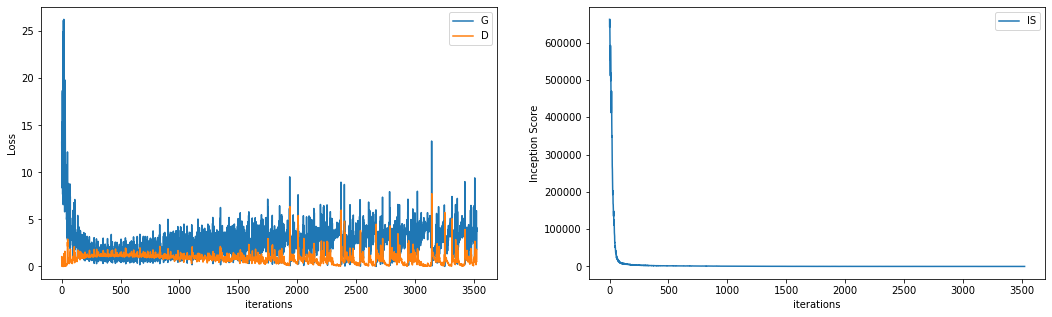

In [71]:
plt.figure(figsize=(18,5))
plt.title("Generator and Discriminator Loss During Training")
plt.subplot(121)
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
# plt.plot(Inception_loss,label="IS")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.subplot(122)
plt.plot(Inception_loss,label="IS")
plt.xlabel("iterations")
plt.ylabel("Inception Score")
plt.legend()
plt.show()

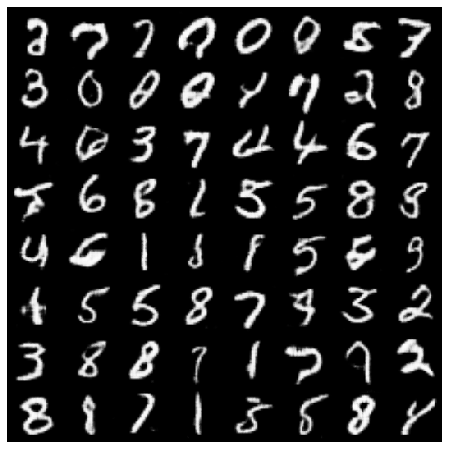

In [72]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

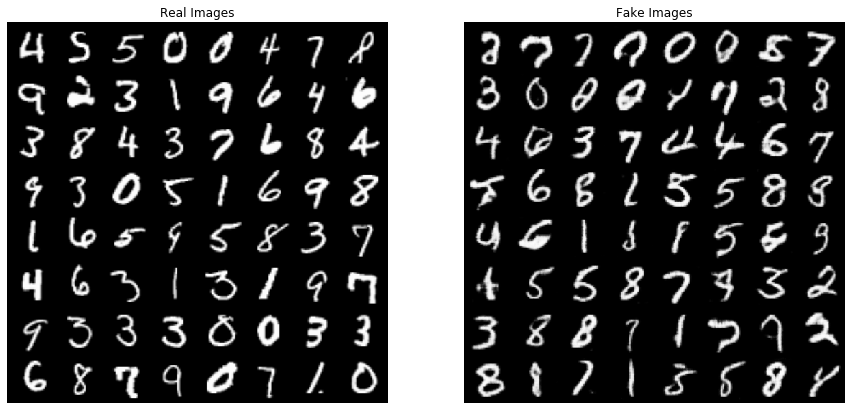

In [73]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()